<a href="https://colab.research.google.com/github/nguyenanhtienabcd/AIO2024_EXERCISE/blob/feature%2FMODULE6-WEEK1-EX1/m06w01_ex1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import random
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.utils.data as data
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from PIL import Image

from  torch.utils.data import Dataset, DataLoader


### Lấy dữ liệu

In [2]:
root = './data'
train_data = datasets.MNIST(root=root, train=True, download=True, transform=transforms.ToTensor())
test_data = datasets.MNIST(root=root, train=False, download=True, transform=transforms.ToTensor())

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9.91M/9.91M [00:00<00:00, 15.9MB/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28.9k/28.9k [00:00<00:00, 474kB/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1.65M/1.65M [00:00<00:00, 4.36MB/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4.54k/4.54k [00:00<00:00, 15.5MB/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



In [3]:
valid_radio = 0.9

n_train_examples = int(len(train_data)*valid_radio)
n_valid_examples = len(train_data) - n_train_examples

train_data, valid_data = data.random_split(train_data, [n_train_examples, n_valid_examples])

# tính toán mean và std khi normalization cho dữ liệu
mean = train_data.dataset.data.float().mean()/255
std = train_data.dataset.data.float().std()/255

train_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean = [mean], std = [std])
])

test_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean = [mean], std = [std])
])

train_data.dataset.transform = train_transforms
valid_data.dataset.transform = test_transforms
test_data.transform = test_transforms

In [4]:
print(len(train_data))
# Get the first image and its label from the train_data Subset
image, label = train_data[0]

# Print the shape of the image
print(image.shape)

54000
torch.Size([1, 28, 28])


In [5]:
# create dataloader
batch_size = 256

train_dataloader = DataLoader(train_data, shuffle=True, batch_size=batch_size)
test_dataloader = DataLoader(valid_data, batch_size=batch_size)


In [6]:
class LeNetClassifier(nn.Module):
  def __init__(self, num_classes):
    super(LeNetClassifier, self).__init__()
    self.conv1 = nn.Conv2d(in_channels=1,
                           out_channels=6,
                           kernel_size=5,
                           stride=1,
                           padding = 'same')
    self.avgpool = nn.AvgPool2d(kernel_size=2)
    self.conv2 = nn.Conv2d(in_channels=6,
                           out_channels=16,
                           kernel_size=5,
                           stride=1,
                           padding = 'same')
    self.avgpool2 = nn.AvgPool2d(kernel_size=2)
    self.flatten = nn.Flatten()
    self.fc1 = nn.Linear(7*7*16, 120)
    self.fc2 = nn.Linear(120, 84)
    self.fc3 = nn.Linear(84, num_classes)

  def forward(self, x):
    out = self.conv1(x)
    out = self.avgpool(out)
    out = F.relu(out)

    out = self.conv2(out)
    out = self.avgpool2(out)
    out = F.relu(out)

    out = self.flatten(out)
    out = self.fc1(out)
    out = self.fc2(out)
    out = self.fc3(out)
    return out


### hàm training

In [7]:
import time
def train(model, optimizer, loss_fn, train_dataloader, device, epoch = 0,
          log_interval = 50):
    model.train()
    total_acc, total_count = 0., 0.
    losses = []
    start_time = time.time()
    for batch, (X, y) in enumerate(train_dataloader):
        X, y = X.to(device), y.to(device)

        optimizer.zero_grad()
        y_pred = model(X)
        loss = loss_fn(y_pred, y)
        losses.append(loss.item())
        loss.backward()
        optimizer.step()

        # mục đích để hạn chế đầu ra của gradient tránh bị explosion gradient
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        #----

        # mục đích đẻ tích dần dần số accuracy sau khi chạy xong epoch
        total_acc += (y_pred.argmax(dim=1) == y).sum().item()
        total_count += y.size(0)

        if batch % log_interval == 0 and batch > 0:
          eslapsed_time = time.time() - start_time
          print('| epoch {:3d} | {:5d}/{:5d} batches '
                '| accuracy {:8.3f}'.format(epoch, batch, len(train_dataloader),
                                            total_acc/total_count))
          total_acc, total_count = 0, 0
          start_time = time.time()

    epoch_acc = total_acc/total_count
    epoch_loss = np.mean(losses)
    return epoch_acc, epoch_loss



### Hàm đánh giá

In [8]:
def evaluate(model, loss_fn, dataloader, device):
  total_acc, total_count = 0., 0.
  losses = []
  model.eval()
  with torch.no_grad():
    for X, y in dataloader:
      X, y = X.to(device), y.to(device)
      y_pred = model(X)
      loss = loss_fn(y_pred, y)
      losses.append(loss.item())

      total_acc += (y_pred.argmax(dim=1) == y).sum().item()
      total_count += y.size(0)
  epoch_acc = total_acc/total_count
  epoch_loss = np.mean(losses)
  return epoch_acc, epoch_loss

### trainning model

In [9]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [10]:
number_class = len(train_data.dataset.classes)
model = LeNetClassifier(number_class).to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)
loss_fn = nn.CrossEntropyLoss()

num_epochs = 10
save_model = './model'

# Create the directory if it doesn't exist
if not os.path.exists(save_model):
    os.makedirs(save_model)

train_acc, loss_acc = [], []
val_acc, val_loss = [], []
best_loss_val = 100

for epoch in range(1, num_epochs+1):
  epoch_train_acc, epoch_train_loss = train(model, optimizer, loss_fn, train_dataloader, device, epoch)
  epoch_val_acc, epoch_val_loss = evaluate(model, loss_fn, test_dataloader, device)
  train_acc.append(epoch_train_acc)
  loss_acc.append(epoch_train_loss)

  val_acc.append(epoch_val_acc)
  val_loss.append(epoch_val_loss)

  # save  best model
  if epoch_val_loss < best_loss_val:
    best_loss_val = epoch_val_loss
    torch.save(model.state_dict(), os.path.join(save_model, 'best_model.pt'))

  print('-' * 59)
  print('| end of epoch {:3d} | train accuracy {:8.3f} | val accuracy {:8.3f} | train loss {:8.3f} | val loss {:8.3f}'.format(epoch,
                                                        epoch_train_acc,
                                                        epoch_val_acc,
                                                        epoch_train_loss,
                                                        epoch_val_loss))

  # load best model
  print('-' * 59)
  model.load_state_dict(torch.load(os.path.join(save_model, 'best_model.pt')))
  model.eval()




| epoch   1 |    50/  211 batches | accuracy    0.719
| epoch   1 |   100/  211 batches | accuracy    0.890
| epoch   1 |   150/  211 batches | accuracy    0.911
| epoch   1 |   200/  211 batches | accuracy    0.929
-----------------------------------------------------------
| end of epoch   1 | train accuracy    0.938 | val accuracy    0.937 | train loss    0.476 | val loss    0.220
-----------------------------------------------------------


<ipython-input-10-38803df4d3e8>:40: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(os.path.join(save_model, 'best_model.pt')))


| epoch   2 |    50/  211 batches | accuracy    0.949
| epoch   2 |   100/  211 batches | accuracy    0.955
| epoch   2 |   150/  211 batches | accuracy    0.956
| epoch   2 |   200/  211 batches | accuracy    0.965
-----------------------------------------------------------
| end of epoch   2 | train accuracy    0.963 | val accuracy    0.964 | train loss    0.149 | val loss    0.127
-----------------------------------------------------------
| epoch   3 |    50/  211 batches | accuracy    0.967
| epoch   3 |   100/  211 batches | accuracy    0.969
| epoch   3 |   150/  211 batches | accuracy    0.972
| epoch   3 |   200/  211 batches | accuracy    0.973
-----------------------------------------------------------
| end of epoch   3 | train accuracy    0.974 | val accuracy    0.969 | train loss    0.096 | val loss    0.106
-----------------------------------------------------------
| epoch   4 |    50/  211 batches | accuracy    0.973
| epoch   4 |   100/  211 batches | accuracy    0.97

In [11]:
# traing with test data
test_dataloader = DataLoader(test_data, batch_size=batch_size)
test_acc, test_loss = evaluate(model, loss_fn, test_dataloader, device)
print('test accuracy: ', test_acc)
print('test loss: ', test_loss)

test accuracy:  0.9869
test loss:  0.04312468100033584


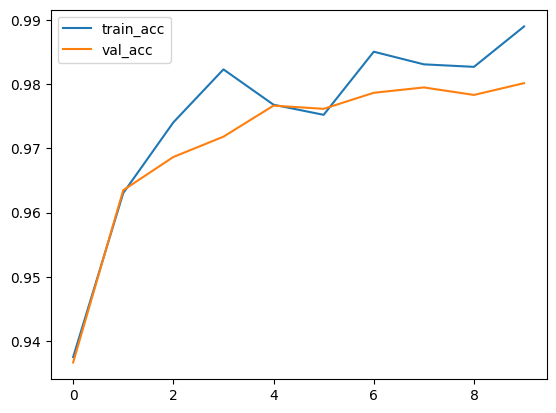

In [12]:
import matplotlib.pyplot as plt
plt.plot(train_acc, label='train_acc')
plt.plot(val_acc, label='val_acc')
plt.legend()
plt.show()